In [1]:
import jax.numpy as jnp
from jax import random, jit, vmap
import matplotlib.pyplot as plt

from quantum_error_correction_code import surface_code

In [2]:
key = random.key(42)
code = surface_code(L=3)

X-error: [0 0 0 1 0 0 0 0 0]
Z-error: [0 0 0 0 0 1 0 1 0]
parity_x=Array([0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)
parity_z=Array([0, 0, 0, 1, 0, 1, 1, 1], dtype=int32)
Syndrome: (Array([0, 0, 1, 1, 0, 1, 1, 1], dtype=int32), Array([0, 1], dtype=int32))
parity_x=Array([0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)
parity_z=Array([0, 0, 0, 1, 0, 1, 1, 1], dtype=int32)


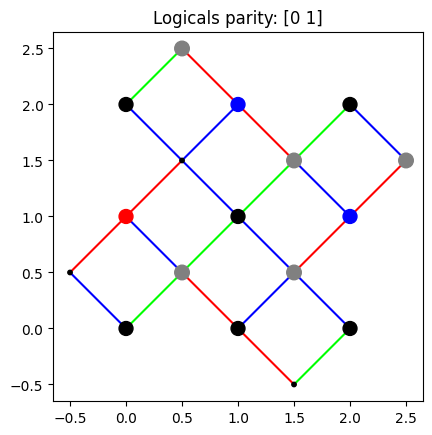

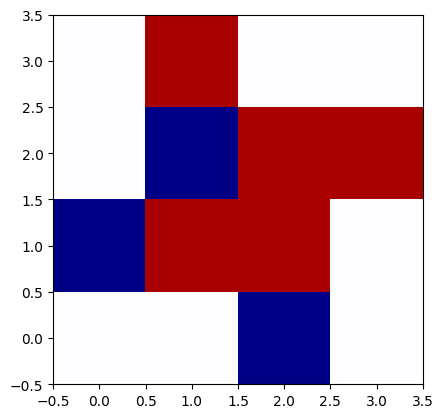

In [30]:
code.apply_deformation(
    jnp.array([2,0,2,3,2,3,2,0,2])
)
# code.apply_deformation(
#     jnp.array([0,0,0,0,0,0,0,0,0])
# )

subkey, key = random.split(key)
error = code.error(
    subkey,
    jnp.array([.05,.05,.05])
)
print("X-error:",error[0].astype(int))
print("Z-error:",error[1].astype(int))
syndrome = code.syndrome(error)
print("Syndrome:",syndrome)


code.show(error)

img, _ = code.syndrome_img(error)

plt.figure()
plt.imshow(img, origin='lower', vmin=-1.2, vmax=1.2, cmap="seismic_r")
plt.show()

In [4]:
BATCH_SIZE = 1000

@jit
def get_data(
    datakey,
    probabilities: jnp.ndarray,
):
    datakey = random.split(datakey, num=BATCH_SIZE+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(datakey[:-1], probabilities)
    imgs, logicals = vmap(
        code.syndrome_img,
    )(errors)
    return imgs[:,None,:,:], logicals, datakey[-1]

In [5]:
datakey = random.key(42)

In [6]:
imgs, logicals, datakey = get_data(datakey, jnp.array([.0,.01,.0]))

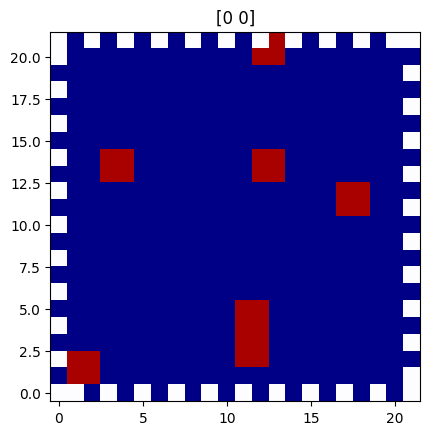

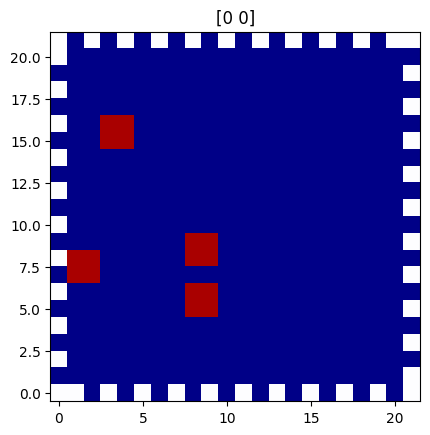

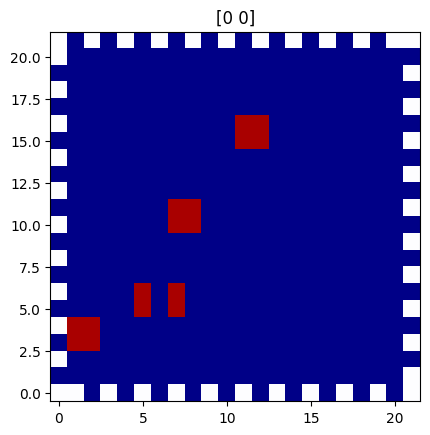

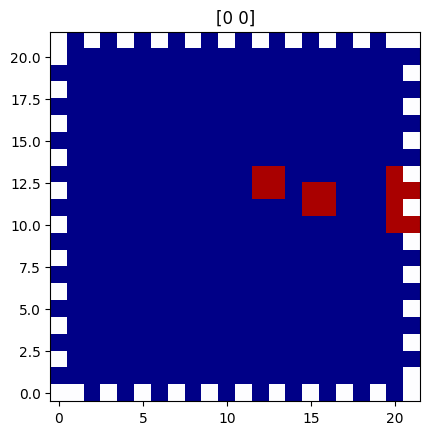

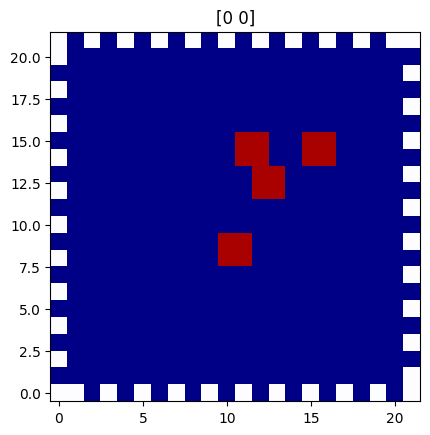

In [7]:
for img, logi in zip(imgs[:5], logicals[:5]):
    plt.figure()
    plt.imshow(img[0], origin='lower', vmin=-1.2, vmax=1.2, cmap="seismic_r")
    plt.title(logi)
    plt.show()